## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data


In [15]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [16]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [17]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [18]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [19]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [20]:
x_df = pd.read_csv('../avg_base_wl_25-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-7.864691,-32.876223,-81.441809,34.100714,-8.329733,-6.084499,39.106688,81.595182,28.367469,-33.549423,...,131.632928,476.037019,1355.860070,1037.412886,289.114382,45.829415,-58.928506,-100.591822,-116.011889,-77.283306
1,-122.419869,-121.975190,-183.580510,-67.385822,-101.341118,-128.096389,-70.851622,-19.806804,-76.861917,-136.066946,...,29.233677,-61.440166,-92.663913,-100.237583,-59.411193,-46.334756,-129.158287,-148.631798,-188.155299,-161.378796
2,-45.938542,-72.597810,-135.657078,-23.249675,-63.075597,-82.768172,-43.860727,14.513414,-45.112407,-88.838180,...,49.048043,-37.678755,-49.138825,-56.865513,-6.225495,-13.052112,-82.745375,-108.538624,-121.998532,-110.125106
3,-74.248689,-88.550836,-140.577119,-24.499950,-75.181390,-101.449020,-59.647659,-6.122125,-58.286200,-98.795044,...,29.181529,-47.446362,-38.177626,-59.701933,-11.295156,-35.509030,-105.136672,-132.660848,-151.702258,-129.226424
4,113.773646,44.218164,13.704347,151.315527,114.676703,158.579536,294.774023,290.760158,130.579601,11.149013,...,30.602823,-51.837138,-114.277028,-83.466863,-16.073320,-37.513078,-93.661145,-119.142531,-138.832243,-109.605286
5,117.523648,28.773685,-0.176279,167.373754,123.123781,157.073801,315.248808,282.623796,105.123761,-5.851304,...,41.124975,-28.011700,-8.773303,-20.259847,-13.946342,-29.982800,-112.469232,-134.580649,-150.592057,-119.403464
6,-46.131274,-59.723018,-111.939761,0.843499,-32.623234,-61.964955,-21.556660,9.601659,-43.864994,-99.831611,...,66.274575,-27.007751,-51.790034,-48.197283,8.395497,13.238299,-57.418883,-87.451055,-95.233222,-76.265387
7,-34.186038,-55.433807,-97.281576,7.020658,-47.677101,-45.024852,3.477412,31.929696,-16.517996,-75.215658,...,79.536750,-14.535058,-18.406821,-4.628546,20.449761,1.178094,-55.443555,-86.315192,-112.586823,-92.858452
8,81.436124,17.374412,-15.946560,126.436168,100.189261,133.164567,238.250968,250.374384,130.719991,26.658148,...,97.588563,8.412306,0.680512,-12.421637,27.142895,21.374104,-32.246530,-35.719011,-66.747045,-31.034337
9,242.174780,126.912135,124.316155,319.220170,283.457508,373.094829,579.232128,543.736064,286.139963,152.310485,...,67.471440,-23.401227,-49.440521,-47.779784,-3.185688,-0.991572,-39.530775,-73.369968,-94.842491,-64.815013


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


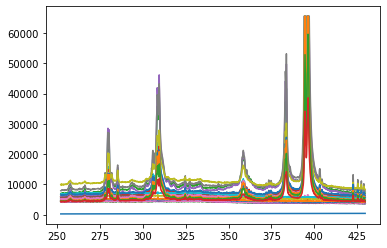

In [21]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('../ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [22]:
df_y = pd.read_csv('../concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Zn,Cu,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [23]:
y_val = concentration[:,3] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[2.94  1.1   0.2   0.293 0.391 0.36  0.036 0.52  1.71  1.26  0.41  0.88
 0.32  0.025 0.77  4.54  0.57  0.39  3.57  0.339 0.363 2.48  1.11  2.03 ]
(24,)


# Genetic Algorithm with PLS

In [10]:
import random

import numpy as np
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression



In [11]:
x_std= snv(values)
print(x_std.shape)

autoscaled_X_train, X_test, autoscaled_y_train, y_test = train_test_split(x_std, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(24, 1446)


NameError: name 'X_train' is not defined

In [48]:
X_train=values
y_train= y_val

autoscaled_X_train= X_train
autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
print(autoscaled_X_train.shape)
print(autoscaled_y_train.shape)

print(np.linalg.matrix_rank(autoscaled_X_train))

(24, 1446)
(24,)
23


In [49]:
# settings
number_of_population = 100
number_of_generation = 200
max_number_of_components = 20
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.2
threshold_of_variable_selection = 0.5


# GAPLS
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
min_boundary = np.zeros(X_train.shape[1])
max_boundary = np.ones(X_train.shape[1]) * 1.0
#print(min_boundary.shape)
#print(max_boundary.shape)


###this one is for selecting at random the "individual"
def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index


toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    individual_array = np.array(individual)
    #individual array is an array of lenght "wl" with values between 0 and 1. 
    #print("individual_array", individual_array.shape)
    
    selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
    #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
    #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)
    
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)

    
    if len(selected_X_variable_numbers):
        # cross-validation
        #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))
        
        #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))
        
        pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                          max_number_of_components + 1), 1)
        #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
        #                                  max_number_of_components + 1), 1)
        #print("pls components: ", pls_components)
        
        r2_cv_all = []
        
        for pls_component in pls_components:
            
            model_in_cv = PLSRegression(n_components=pls_component)
            
            #print("selected_autoscaled_X_train",selected_autoscaled_X_train)
            
            estimated_y_train_in_cv = np.ndarray.flatten(
                model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))
            
            
            
            estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
            r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
        #print(len(r2_cv_all))
        #print("r2_cv_all: ",r2_cv_all)
        """
        try:
            value = np.max(r2_cv_all)
        except ValueError:  #raised if `y` is empty.
            value = -999
            pass
        """
        value = np.max(r2_cv_all)
        
    else:
        value = -999

    return value,


toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

# random.seed(100)
random.seed()
pop = toolbox.population(n=number_of_population)

print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

Start of evolution
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 60 individuals
  Min -0.12187485694221922
  Max 0.015955999799973086
  Avg -0.02509427453239783
  Std 0.021853850255225814
-- Generation 2 --
  Evaluated 58 individuals
  Min -0.05676867459474866
  Max 0.02299140325064175
  Avg -0.009121053846036457
  Std 0.015059656923307562
-- Generation 3 --
  Evaluated 55 individuals
  Min -0.04029952835768347
  Max 0.03916325732585624
  Avg 0.0004984529183365505
  Std 0.013400980538484755
-- Generation 4 --
  Evaluated 69 individuals
  Min -0.04992460902736684
  Max 0.04554161877174301
  Avg 0.009658838481485708
  Std 0.016748335207530215
-- Generation 5 --
  Evaluated 58 individuals
  Min -0.010858515443143979
  Max 0.05625128124367618
  Avg 0.023909630360397092
  Std 0.014445061834636296
-- Generation 6 --
  Evaluated 59 individuals
  Min -0.0027956084325788666
  Max 0.06582908497739648
  Avg 0.03432449295721227
  Std 0.013067909302620792
-- Generation 7 --
  Evaluated

  Evaluated 60 individuals
  Min 0.19324996892511326
  Max 0.23120942030763347
  Avg 0.22157095445319258
  Std 0.006805923922118916
-- Generation 56 --
  Evaluated 65 individuals
  Min 0.19569066011074843
  Max 0.23120942030763347
  Avg 0.222466721799425
  Std 0.00699129274616893
-- Generation 57 --
  Evaluated 62 individuals
  Min 0.18669690976165387
  Max 0.23375092258982044
  Avg 0.22448172510854328
  Std 0.007750637812141016
-- Generation 58 --
  Evaluated 49 individuals
  Min 0.1994105878877237
  Max 0.23536716000384295
  Avg 0.22598345876293022
  Std 0.0072375186182040245
-- Generation 59 --
  Evaluated 53 individuals
  Min 0.18055240537519968
  Max 0.23942489910928544
  Avg 0.22612670946556362
  Std 0.010500334742549291
-- Generation 60 --
  Evaluated 50 individuals
  Min 0.2012925101467513
  Max 0.24133957605243583
  Avg 0.22889277962730312
  Std 0.008662582348479666
-- Generation 61 --
  Evaluated 54 individuals
  Min 0.19813772732219181
  Max 0.24147952606951306
  Avg 0.23083

  Evaluated 68 individuals
  Min 0.2233054625756914
  Max 0.26863673547417377
  Avg 0.26145703017615946
  Std 0.011106328119408414
-- Generation 111 --
  Evaluated 62 individuals
  Min 0.2082021062168845
  Max 0.26863673547417377
  Avg 0.26109269636206067
  Std 0.012581440069783827
-- Generation 112 --
  Evaluated 63 individuals
  Min 0.235872004138875
  Max 0.26992919923011216
  Avg 0.26464921717115336
  Std 0.007179206835951195
-- Generation 113 --
  Evaluated 62 individuals
  Min 0.21554495074747182
  Max 0.26992919923011216
  Avg 0.26378540414896323
  Std 0.009770707320889032
-- Generation 114 --
  Evaluated 49 individuals
  Min 0.22522382936317986
  Max 0.27016610037753674
  Avg 0.264389001112123
  Std 0.008706938965853324
-- Generation 115 --
  Evaluated 61 individuals
  Min 0.23675560693702935
  Max 0.27016610037753674
  Avg 0.2639193789843921
  Std 0.00891936017490574
-- Generation 116 --
  Evaluated 63 individuals
  Min 0.23647257419403922
  Max 0.2717218699317162
  Avg 0.2646

  Evaluated 51 individuals
  Min 0.2315844717724046
  Max 0.2919057722894205
  Avg 0.2870354991026336
  Std 0.01228221770043551
-- Generation 166 --
  Evaluated 57 individuals
  Min 0.25106267700785334
  Max 0.2919057722894205
  Avg 0.28775373376404784
  Std 0.010167450668036369
-- Generation 167 --
  Evaluated 55 individuals
  Min 0.24091826114169201
  Max 0.2919057722894205
  Avg 0.2869551354745047
  Std 0.011004492714891491
-- Generation 168 --
  Evaluated 63 individuals
  Min 0.24023792025174773
  Max 0.2919057722894205
  Avg 0.28593225356477825
  Std 0.012235028598398444
-- Generation 169 --
  Evaluated 62 individuals
  Min 0.24566341796843083
  Max 0.2919057722894205
  Avg 0.28585740584119246
  Std 0.011389117059537593
-- Generation 170 --
  Evaluated 75 individuals
  Min 0.2548830633911269
  Max 0.2919057722894205
  Avg 0.2865089300850363
  Std 0.010416938148759736
-- Generation 171 --
  Evaluated 66 individuals
  Min 0.2555289973657089
  Max 0.2919057722894205
  Avg 0.287225856

In [50]:
selected_X_variable_numbers.shape

(460,)

In [51]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 460) (19, 1)
(5, 460) (5, 1)
       0
22  1.11
12  0.32
17  0.39
15  4.54
14  0.77


37% completed
Suggested number of components:  4



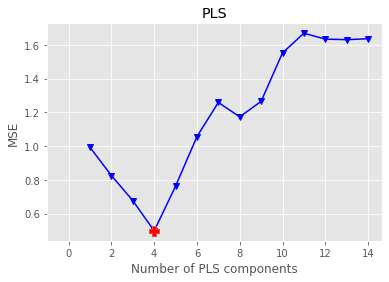

R2 calib: 0.813
R2 CV: 0.518
MSE calib: 0.194
MSE CV: 0.498


In [53]:
optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  0.18631249884058643
RMSE:  1.427613003024291



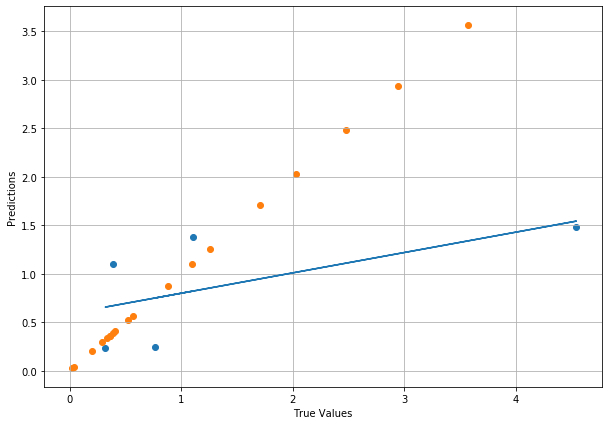

In [58]:
# Define PLS object
pls = PLSRegression(n_components=20)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [12]:
# -*- coding: utf-8 -*- 
# %reset -f
"""
@author: Hiromasa Kaneko
"""
# Demonstration of (binary) Genetic Algorithm-based Partial Least Squares (GAPLS)


import random

import numpy as np
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression

# settings
number_of_population = 100
number_of_generation = 150
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.2
threshold_of_variable_selection = 0.5

# generate sample dataset
X_train, y_train = datasets.make_regression(n_samples=100, n_features=300, n_informative=10, noise=10, random_state=0)

# autoscaling
autoscaled_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
#autoscaled_X_train = X_train
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#autoscaled_y_train = y_train
print(autoscaled_X_train.shape)
print(autoscaled_y_train.shape)


# GAPLS
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
min_boundary = np.zeros(X_train.shape[1])
max_boundary = np.ones(X_train.shape[1]) * 1.0


def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index


toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    individual_array = np.array(individual)
    selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    
    #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)
    
    if len(selected_X_variable_numbers):
        # cross-validation
        
        #print("np.linalg.matrix_rank(selected_autoscaled_X_train", np.linalg.matrix_rank(selected_autoscaled_X_train))
        
        ### THIS IS MY MODIFICATION OF THE ALGORITHM
        pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                          max_number_of_components + 1), 1)
        
        #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
         #                                 max_number_of_components + 1), 1)
        r2_cv_all = []
        for pls_component in pls_components:
            model_in_cv = PLSRegression(n_components=pls_component)
            estimated_y_train_in_cv = np.ndarray.flatten(
                model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train,
                                                  cv=fold_number))
            estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
            r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
        value = np.max(r2_cv_all)
    else:
        value = -999

    return value,


toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

# random.seed(100)
random.seed()
pop = toolbox.population(n=number_of_population)

print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

(100, 300)
(100,)
Start of evolution
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 53 individuals
  Min -11067.233144441487
  Max -7474.0937260201
  Avg -9355.296608860162
  Std 686.7273315690823
-- Generation 2 --
  Evaluated 65 individuals
  Min -9949.338627869049
  Max -6995.36057687397
  Avg -8806.443169190885
  Std 536.0016759635755
-- Generation 3 --
  Evaluated 58 individuals
  Min -9494.860218530916
  Max -6967.653506932216
  Avg -8336.990633819893
  Std 568.9917503605409
-- Generation 4 --
  Evaluated 59 individuals
  Min -9366.694460621517
  Max -6876.648209208637
  Avg -7876.34822198962
  Std 587.4312620638225
-- Generation 5 --


KeyboardInterrupt: 

In [117]:
# -*- coding: utf-8 -*- 
# %reset -f
"""
@author: Hiromasa Kaneko
"""
# Demonstration of (binary) Genetic Algorithm-based Partial Least Squares (GAPLS)


import random

import numpy as np
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression

# settings
number_of_population = 100
number_of_generation = 150
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.2
threshold_of_variable_selection = 0.5

# generate sample dataset
X_train, y_train = datasets.make_regression(n_samples=100, n_features=300, n_informative=10, noise=10, random_state=0)

# autoscaling
autoscaled_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
#autoscaled_X_train = X_train
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#autoscaled_y_train = y_train
print(autoscaled_X_train.shape)
print(autoscaled_y_train.shape)


# GAPLS
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
min_boundary = np.zeros(X_train.shape[1])
max_boundary = np.ones(X_train.shape[1]) * 1.0


def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index


toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    individual_array = np.array(individual)
    selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    
    #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)
    
    if len(selected_X_variable_numbers):
        # cross-validation
        
        #print("np.linalg.matrix_rank(selected_autoscaled_X_train", np.linalg.matrix_rank(selected_autoscaled_X_train))
        
        ### THIS IS MY MODIFICATION OF THE ALGORITHM
        pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                          max_number_of_components + 1), 1)
        
        #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
         #                                 max_number_of_components + 1), 1)
        r2_cv_all = []
        for pls_component in pls_components:
            model_in_cv = PLSRegression(n_components=pls_component)
            estimated_y_train_in_cv = np.ndarray.flatten(
                model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train,
                                                  cv=fold_number))
            estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
            r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
        value = np.max(r2_cv_all)
    else:
        value = -999

    return value,


toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

# random.seed(100)
random.seed()
pop = toolbox.population(n=number_of_population)

print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

(100, 300)
(100,)
Start of evolution
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 64 individuals
  Min -0.2624933541950494
  Max 0.46170756718616024
  Avg 0.14267219705004808
  Std 0.14881491527603397
-- Generation 2 --
  Evaluated 58 individuals
  Min -0.16039377957377243
  Max 0.49361513086543063
  Avg 0.2632540505603719
  Std 0.12259475817814904
-- Generation 3 --
  Evaluated 59 individuals
  Min 0.04498058469883337
  Max 0.6113113283881253
  Avg 0.35039711113622274
  Std 0.08879021686133548
-- Generation 4 --
  Evaluated 64 individuals
  Min 0.07704270283454695
  Max 0.6566606322454047
  Avg 0.4148732330680762
  Std 0.09050431314455466
-- Generation 5 --
  Evaluated 63 individuals
  Min 0.10013567022875891
  Max 0.6647248014971939
  Avg 0.4581790166493427
  Std 0.09455475013174726
-- Generation 6 --
  Evaluated 55 individuals
  Min 0.08025124606066136
  Max 0.6647248014971939
  Avg 0.5040987543646974
  Std 0.08674545476744416
-- Generation 7 --
  Evaluated 56 individu

KeyboardInterrupt: 

In [120]:
x_df.shape

(24, 1446)

In [121]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [122]:
selected_X_variable_numbers.shape

(87,)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 87) (19, 1)
(5, 87) (5, 1)
        0
9   1.260
23  2.030
12  0.320
3   0.293
4   0.391


# Principal Components Analysis

In [11]:
n_components=20


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[32.16 58.34 69.76 79.23 85.78 89.43 91.66 93.69 95.11 96.32 97.1  97.7
 98.23 98.57 98.83 99.08 99.28 99.46 99.61 99.75]


In [12]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9848340523115449 -15.14649505941636
0.020707936081303502 22.046798162306988


now using PCA with Linear regression and PLS

In [13]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 1446)
(1446,)
19
(19, 15)
[31.39 57.97 69.86 78.68 86.   90.19 92.52 94.59 95.99 97.29 97.94 98.58
 98.98 99.31 99.55]


In [14]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -2.140162453328776
MSE:  2.221136886011957


37% completed
Suggested number of components:  1



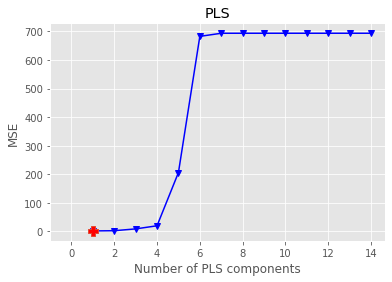

R2 calib: 0.842
R2 CV: -0.248
MSE calib: 0.243
MSE CV: 1.919


In [15]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [16]:
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -2.140162453328775
MSE:  2.2211368860119567


# Partial Least Square Regression

In [23]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [59]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  15
Wavelengths to be discarded  425
Optimised MSEP  0.49675545421355377

--- 77.95738959312439 seconds ---


sorted wavelengths:  [301.3314 300.8193 268.3223 292.9937 268.452  275.5789 298.1286 270.527
 294.0217 291.0649]


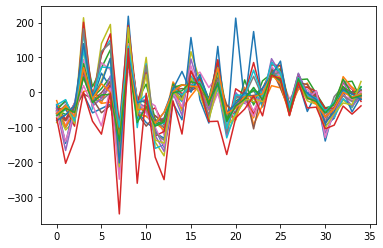

In [60]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [91]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 460) (19, 1)
(5, 460) (5, 1)
        0
17  0.390
3   0.293
13  0.025
21  2.480
12  0.320


100% completed
Suggested number of components:  2



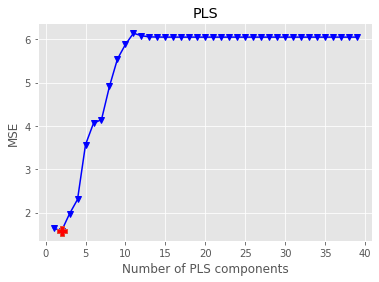

R2 calib: 0.498
R2 CV: -0.083
MSE calib: 0.731
MSE CV: 1.578


In [92]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  0.11686689906998804
RMSE:  0.8437024069900261



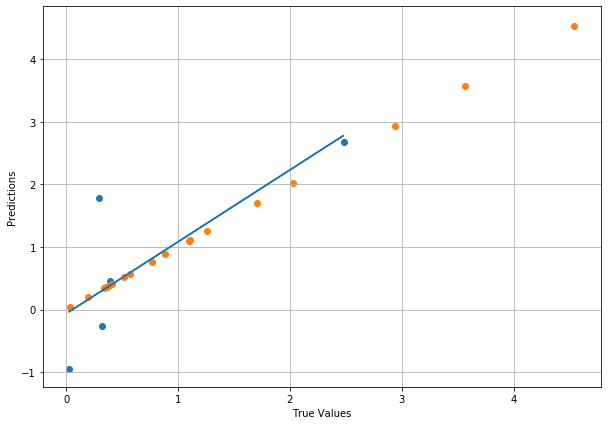

In [93]:
# Define PLS object
pls = PLSRegression(n_components=15)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [94]:
Xn_train = normalize(X_train, axis=0)
Xn_test = normalize(X_test, axis=0)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 460)
(5, 460)


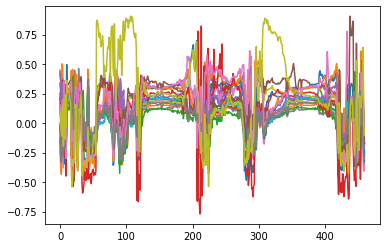

In [76]:
plt.plot(Xn_train.T)
plt.show()

In [77]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  -0.35157690020939647
RMSE:  1.83993318665056

TEST
 [real, predictions]
[[1.11       3.92738342]
 [0.32       1.50206366]
 [0.39       3.01615632]
 [4.54       3.7448822 ]
 [0.77       0.5191266 ]]



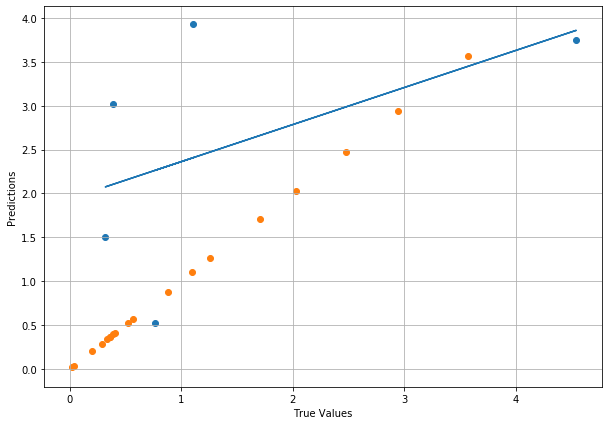

In [78]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [69]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

TypeError: '(0, slice(None, None, None))' is an invalid key

In [70]:
plt.plot(Xs_train.T)
plt.show()

NameError: name 'Xs_train' is not defined

In [71]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

NameError: name 'Xs_train' is not defined

## Using Max-norm

In [88]:
Xm_train = X_train / np.max(X_train, axis=0)
Xm_test = X_test / np.max(X_test, axis=0)


#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 15, plot_components=True)

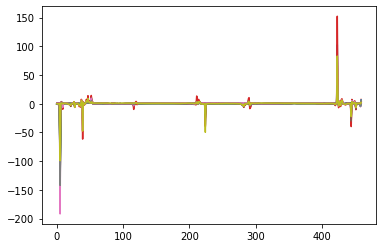

In [89]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  -2.3148155002054147
RMSE:  2.8814517582716026

TEST
 [real, predictions]
[[ 1.11        3.47771382]
 [ 0.32        1.0686273 ]
 [ 0.39        2.62728033]
 [ 4.54        0.94439093]
 [ 0.77       -3.40294641]]



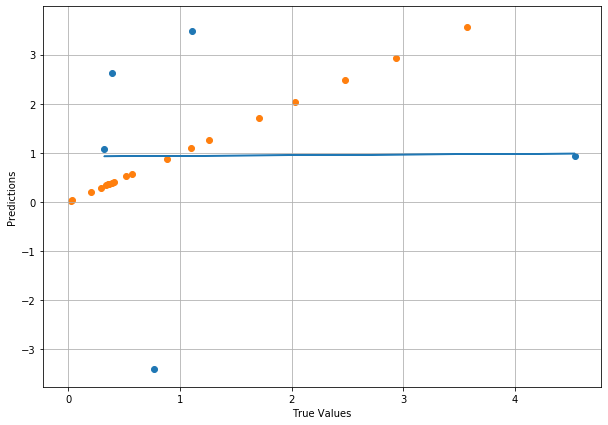

In [90]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


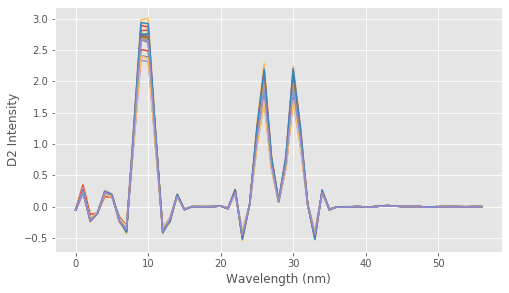

100% completed
Suggested number of components:  8



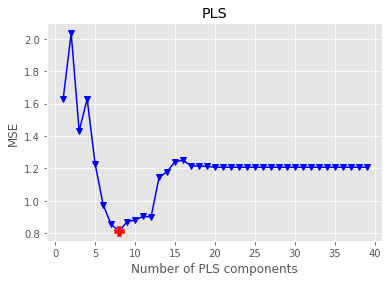

R2 calib: 0.956
R2 CV: 0.404
MSE calib: 0.060
MSE CV: 0.813


In [41]:
# Calculate second derivative
X2 = savgol_filter(opt_Xc, 11, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    

    
optimise_pls_cv(X2, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  1



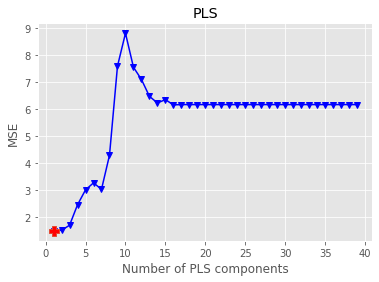

R2 calib: 0.169
R2 CV: -0.027
MSE calib: 1.211
MSE CV: 1.497


In [42]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -2586.547461785336
R2_cv:  -0.690675692387712

[real, predictions]
[[ 3.90000000e-01 -4.48737877e+01]
 [ 2.93000000e-01 -4.61390595e+01]
 [ 2.50000000e-02 -3.88958047e+01]
 [ 2.48000000e+00 -4.94609327e+01]
 [ 3.20000000e-01 -4.45219137e+01]]


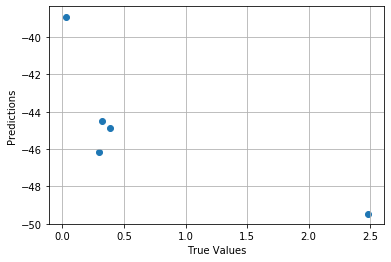

In [43]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [49]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [50]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.31, MSE:2.86, RMSE:1.69
Alpha:0.0010, R2:0.06, MSE:2.69, RMSE:1.64
Alpha:0.0100, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.1000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.3000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.5000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:0.7000, R2:0.00, MSE:2.67, RMSE:1.63
Alpha:1.0000, R2:0.00, MSE:2.67, RMSE:1.63


In [53]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.30735234558204294
RMSE:  1.692288364509511
R^2:  -0.14336631154891522


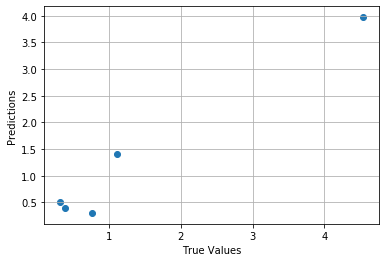

In [52]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [25]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(4,)
(20,)


RMSE:  2.0107659208266253
R^2:  -0.16835577941126534 

[real, predictions]
[[0.391     0.751814 ]
 [0.036     1.57471  ]
 [4.54      0.8524968]
 [0.339     0.6168908]]


Text(0, 0.5, 'Predictions')

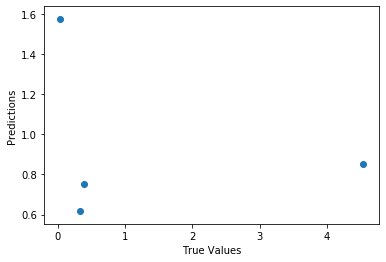

In [26]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

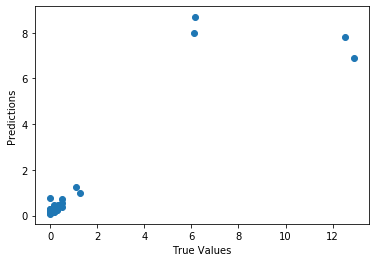

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



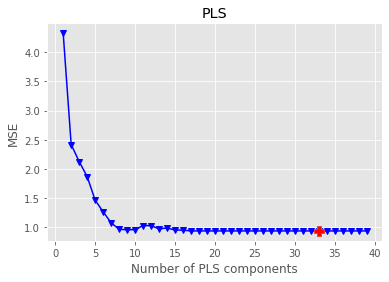

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
